# Fish Classification using timm

# 1. Data preprocessing

In [50]:
import os

path = './fishData_resize'

labels = [something for something in os.listdir(path) if os.path.isdir(path + '/' + something)]
data = [path + ('/' + label) + '/' + f for label in labels for f in sorted(os.listdir(path + ('/' + label)))]
labels = [d[len(path) + 1:].split('/')[0] for d in data] # update

data[:5], labels[:5]

(['./fishData_resize/전갱이/ColorJitter10.png',
  './fishData_resize/전갱이/ColorJitter102.png',
  './fishData_resize/전갱이/ColorJitter105.png',
  './fishData_resize/전갱이/ColorJitter110.png',
  './fishData_resize/전갱이/ColorJitter117.png'],
 ['전갱이', '전갱이', '전갱이', '전갱이', '전갱이'])

# 2. DataFrame

#### Make DataFrame for data verification.

In [51]:
import pandas as pd

df = pd.DataFrame({'data_path': [d[len(path):] for d in data], 'label': labels})
df.head()

,data_path,label
0,/전갱이/ColorJitter10.png,전갱이
1,/전갱이/ColorJitter102.png,전갱이
2,/전갱이/ColorJitter105.png,전갱이
3,/전갱이/ColorJitter110.png,전갱이
4,/전갱이/ColorJitter117.png,전갱이


#### Check null data

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data_path  10000 non-null  object
 1   label      10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


#### Each data count

In [53]:
df['label'].value_counts()

전갱이    1000
황아귀     1000
도루묵     1000
참조기     1000
갈치       1000
청어       1000
멸치       1000
삼치       1000
방어       1000
고등어     1000
Name: label, dtype: int64

# 3. Sample images

#### Show each fish images.

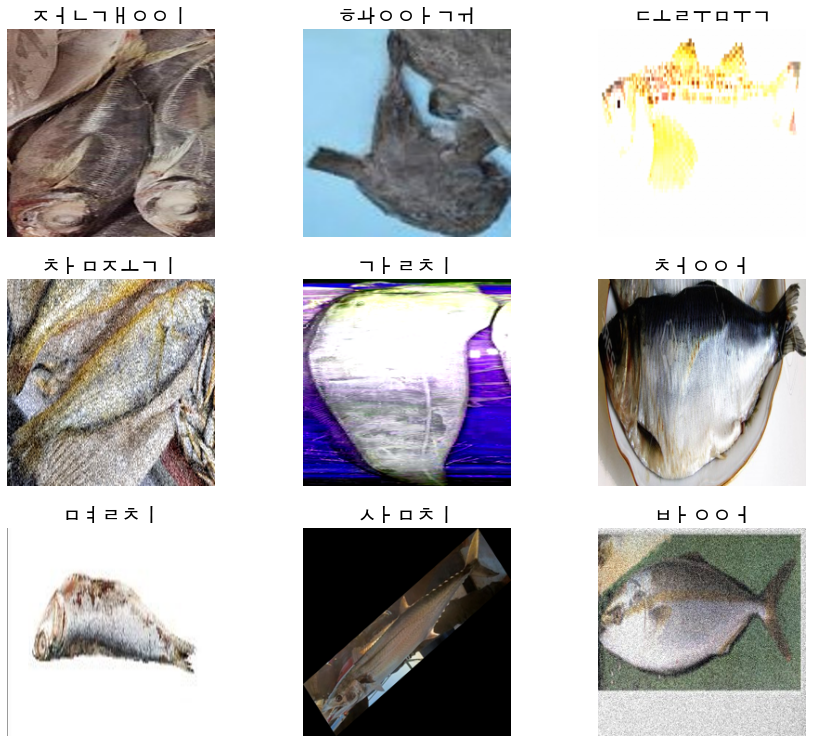

In [54]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# for 한글 폰트
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'AppleGothic'

# choose each one fish
fishes = list(df['label'].value_counts().index)
fishes_example = [random.sample(list(df[df['label'] == fish]['data_path']), 1) for fish in fishes]

row = col = 3
figure = plt.figure(figsize = (15, 13))

for r in range(row):
    for c in range(col):
        ax = figure.add_subplot(row, col, r * col + c + 1)
        ax.imshow(mpimg.imread(path + fishes_example[r * col + c][0]))
        ax.set_title(fishes[r * col + c], fontsize = 20)
        ax.axis("off")
plt.show()

# 4. Dataset

#### Make custom dataset.

In [55]:
label_to_int = {}
int_to_label = {}
for i, label in enumerate(df['label'].value_counts().index):
    label_to_int[label] = i
    int_to_label[i] = label
label_to_int

{'전갱이': 0,
 '황아귀': 1,
 '도루묵': 2,
 '참조기': 3,
 '갈치': 4,
 '청어': 5,
 '멸치': 6,
 '삼치': 7,
 '방어': 8,
 '고등어': 9}

In [56]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

class FishDataset(Dataset):
    def __init__(self, file_name, labels, path, transform = transforms.ToTensor()):
        self.file_name = file_name.tolist()
        self.labels = [label_to_int[label] for label in labels]
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.transform(Image.open(self.path + self.file_name[idx])), self.labels[idx])

#### Calculate mean & standard

In [57]:
batch_size = 32
shuffle = True

data_set = FishDataset(df['data_path'], df['label'], path)
total_loader = DataLoader(dataset = data_set, batch_size = batch_size, shuffle = shuffle)

In [58]:
import torch
from tqdm.auto import tqdm

total_sum, total_square_root_sum, batch_count = 0.0, 0.0, 0
for data, _ in tqdm(total_loader, position = 0):
    total_sum += torch.mean(data, dim = [0, 2, 3])
    total_square_root_sum += torch.mean(data ** 2, dim = [0, 2, 3])
    batch_count += 1
total_mean = total_sum / batch_count
total_std = (total_square_root_sum / batch_count - total_mean ** 2) ** 0.5
total_mean, total_std

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([0.5141, 0.5139, 0.5027]), tensor([0.3240, 0.3200, 0.3234]))

#### Set transforms

In [59]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = total_mean, std = total_std)
])
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=tensor([0.5141, 0.5139, 0.5027]), std=tensor([0.3240, 0.3200, 0.3234]))
)

#### Split dataset

In [60]:
from sklearn.model_selection import train_test_split
import numpy as np

train_data, test_data, train_answer, test_answer = train_test_split(df['data_path'], df['label'], test_size = 0.3, stratify = df['label'])

train_set = FishDataset(train_data, train_answer, path, transform)
test_set = FishDataset(test_data, test_answer, path, transform)

print('Train data count =', np.unique(train_answer, return_counts = True)[1])
print('Test data count =', np.unique(test_answer, return_counts = True)[1])

Train data count = [700 700 700 700 700 700 700 700 700 700]
Test data count = [300 300 300 300 300 300 300 300 300 300]


In [61]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = shuffle)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = shuffle)
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

#### Show image with transform applied

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


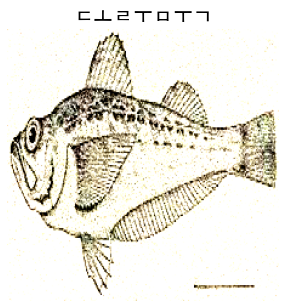

In [62]:
one_image, one_label = next(iter(train_loader))
one_image = one_image[0]
one_label = int_to_label[one_label[0].item()]

plt.figure(figsize = (7, 5))
plt.imshow(one_image.permute(1, 2, 0)) # torch(channel, height, width) -> plt(width, height, channel)
plt.title(one_label, fontsize = 20)
plt.axis('off')
plt.show()

# 5. Model

#### Install timm package

In [63]:
!pip install timm

In [64]:
import timm

print('Number of models available =', len(timm.list_models(pretrained = True)))

Number of models available = 709


#### Set models

In [65]:
num_classes = len(label_to_int)
model_names = ['efficientnet_b0', 'efficientnet_b4', 'nfnet_l0']
models = []
for model_name in model_names:
    models.append(timm.create_model(model_name, pretrained = True, num_classes = num_classes))
[model.__class__ for model in models]

[timm.models.efficientnet.EfficientNet,
 timm.models.efficientnet.EfficientNet,
 timm.models.nfnet.NormFreeNet]

# 6. Train

In [66]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
learning_rate = 0.0001

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizers = []
for model in models:
    optimizers.append(torch.optim.Adam(model.parameters(), lr = learning_rate))
device

'mps'

#### train cell

check **accuracy**.

In [67]:
epochs = 5
train_lastest_accuracy = []
for name, model, optimizer in zip(model_names, models, optimizers):
    model = model.to(device)
    model.train()
    for epoch in tqdm(range(1, epochs + 1), position = 0):
        train_loss = 0
        train_accuracy = 0
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            output = model(data)
            loss = criterion(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predict = output.max(1)[1]
            train_accuracy += predict.eq(targets).sum().item()
        else:
            train_loss /= len(train_loader)
            train_accuracy *= (100 / len(train_loader.dataset))
            print("Train Result of {} : Epoch = {} -> Loss = {:.4f}, Accuracy = {:.4f}%".format(name, epoch, train_loss, train_accuracy))
    else:
        train_lastest_accuracy.append(train_accuracy)
train_lastest_accuracy

  0%|          | 0/5 [00:00<?, ?it/s]

Train Result of efficientnet_b0 : Epoch = 1 -> Loss = 0.9515, Accuracy = 72.7571%
Train Result of efficientnet_b0 : Epoch = 2 -> Loss = 0.0872, Accuracy = 97.5429%
Train Result of efficientnet_b0 : Epoch = 3 -> Loss = 0.0287, Accuracy = 99.4000%
Train Result of efficientnet_b0 : Epoch = 4 -> Loss = 0.0174, Accuracy = 99.6429%
Train Result of efficientnet_b0 : Epoch = 5 -> Loss = 0.0111, Accuracy = 99.8429%


  0%|          | 0/5 [00:00<?, ?it/s]

Train Result of efficientnet_b4 : Epoch = 1 -> Loss = 1.2304, Accuracy = 60.9286%
Train Result of efficientnet_b4 : Epoch = 2 -> Loss = 0.2034, Accuracy = 94.5286%
Train Result of efficientnet_b4 : Epoch = 3 -> Loss = 0.0556, Accuracy = 98.6286%
Train Result of efficientnet_b4 : Epoch = 4 -> Loss = 0.0200, Accuracy = 99.7000%
Train Result of efficientnet_b4 : Epoch = 5 -> Loss = 0.0125, Accuracy = 99.7143%


  0%|          | 0/5 [00:00<?, ?it/s]

Train Result of nfnet_l0 : Epoch = 1 -> Loss = 0.3227, Accuracy = 90.3714%
Train Result of nfnet_l0 : Epoch = 2 -> Loss = 0.0221, Accuracy = 99.3857%
Train Result of nfnet_l0 : Epoch = 3 -> Loss = 0.0212, Accuracy = 99.3286%
Train Result of nfnet_l0 : Epoch = 4 -> Loss = 0.0139, Accuracy = 99.5429%
Train Result of nfnet_l0 : Epoch = 5 -> Loss = 0.0120, Accuracy = 99.6000%


[99.84285714285714, 99.71428571428571, 99.6]

In [68]:
print(models[1])

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

# 7. Test

#### Create ensemble models proportional to accuracy

In [69]:
class AccuracyEnsemble(torch.nn.Module):
    def __init__(self, models, train_accuracy = [1 / len(models)] * len(models)):
        super(AccuracyEnsemble, self).__init__()
        self.models = models
        self.weights = torch.tensor(train_accuracy)
        
    def forward(self, x):
        total_output = 0
        for weight, model in zip(self.weights, self.models):
            total_output += weight * model(x)
        return total_output

In [70]:
ensemble = AccuracyEnsemble(models, train_lastest_accuracy).to(device)
ensemble.weights.tolist()

[99.84285736083984, 99.71428680419922, 99.5999984741211]

#### Test cell

Check **accuracy**. **F1-score**.

In [71]:
ensemble = ensemble.to(device)
for model in models:
    model.eval()
ensemble.eval()

test_predict_list = []
test_answer_list = []
with torch.no_grad():
    test_loss = 0
    test_accuracy = 0
    for data, targets in tqdm(test_loader, position = 0):
        data = data.to(device)
        targets = targets.to(device)

        output = ensemble(data)

        test_loss += criterion(output, targets).item()
        predict = output.max(1)[1]
        test_accuracy += predict.eq(targets).sum().item()
        
        test_predict_list.extend(predict.tolist())
        test_answer_list.extend(targets.tolist())
    else:
        test_loss /= len(test_loader)
        test_accuracy *= (100 / len(test_loader.dataset))
        print("Test Result of ensemble : Loss -> {:.4f}, Accuracy = {:.4f}%".format(test_loss, test_accuracy))

  0%|          | 0/94 [00:00<?, ?it/s]

Test Result of ensemble : Loss -> inf, Accuracy = 99.8333%


#### Confusion matrix

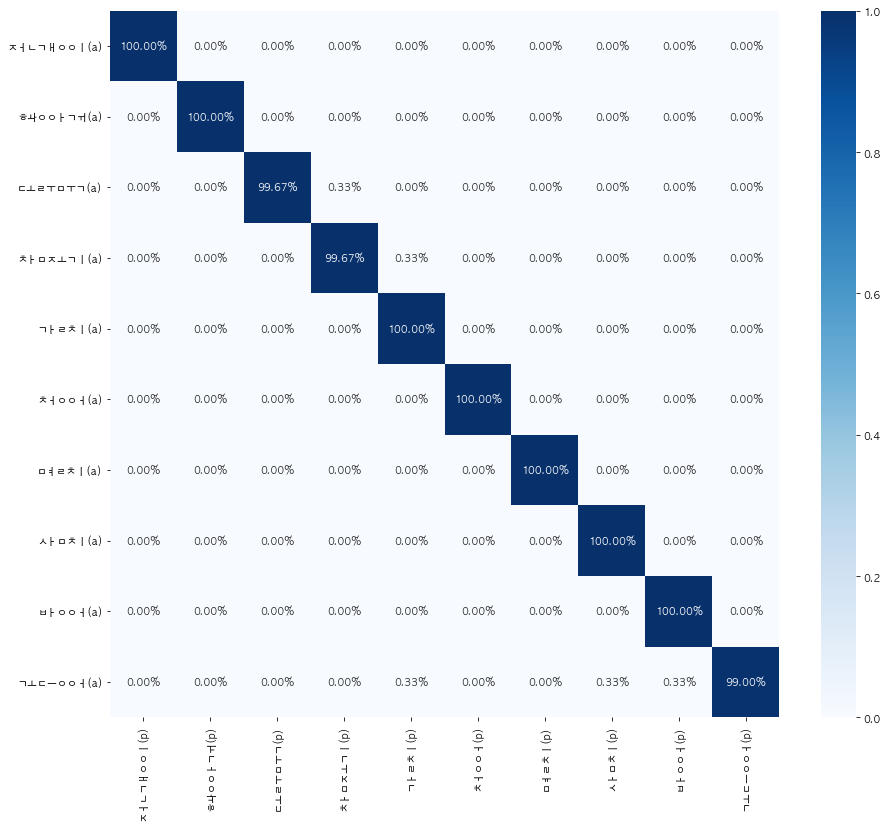

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(test_answer_list, test_predict_list, normalize = 'true')
plt.figure(figsize = (15, 13))
sns.heatmap(cf_matrix, annot = True, fmt = '.2%', cmap = 'Blues', xticklabels = [p + '(p)' for p in label_to_int], yticklabels = [a + '(a)' for a in label_to_int])
plt.show()

# 8. Save & Load model 

#### Save model

In [74]:
efficientnet_b0_model_name = 'efficientnet_b0_5epoch.pt'
efficientnet_b4_model_name = 'efficientnet_b4_5epoch.pt'
nfnet_l0_model_name = 'nfnet_l0_5epoch.pt'

torch.save(models[0].state_dict(), efficientnet_b0_model_name)
torch.save(models[1].state_dict(), efficientnet_b4_model_name)
torch.save(models[2].state_dict(), nfnet_l0_model_name)

In [75]:
ensemble_model_name = 'fish_ensemble_model.pt'
torch.save(ensemble.state_dict(), ensemble_model_name)

#### Load model

In [76]:
ensemble = AccuracyEnsemble(models, train_lastest_accuracy)
ensemble.load_state_dict(torch.load(ensemble_model_name), strict = False)

<All keys matched successfully>

#### Sample test

In [ ]:
ensemble = ensemble.to(device)
ensemble.eval()
data, target = next(iter(test_loader))
sample_predict_list = ensemble(data.to(device)).max(1)[1].tolist()
sample_answer_list = target.to(device).tolist()
print('Predict =', [int_to_label[p] for p in sample_predict_list])
print()
print('Answer  =', [int_to_label[a] for a in sample_answer_list])

In [49]:
from sklearn.metrics import classification_report

CATEGORIES = ['전갱이', '황아귀', '도루묵', '참조기', '갈치', '청어', '멸치', '삼치', '방어', '고등어']
print(classification_report(targets, predict.argmax(), target_names=CATEGORIES))


TypeError: Singleton array tensor(2, device='mps:0') cannot be considered a valid collection.